# Lab 7

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import Counter
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle


###  Load the Labeled Faces in the Wild (LFW) dataset from Sciki

In [15]:
faces = fetch_lfw_people(min_faces_per_person=100, slice_=None)
faces.images = faces.images[:, 35:97, 39:86]
faces.data = faces.images.reshape(faces.images.shape[0], faces.images.shape[1] * faces.images.shape[2])



## Class Balance

### Check Class Balance

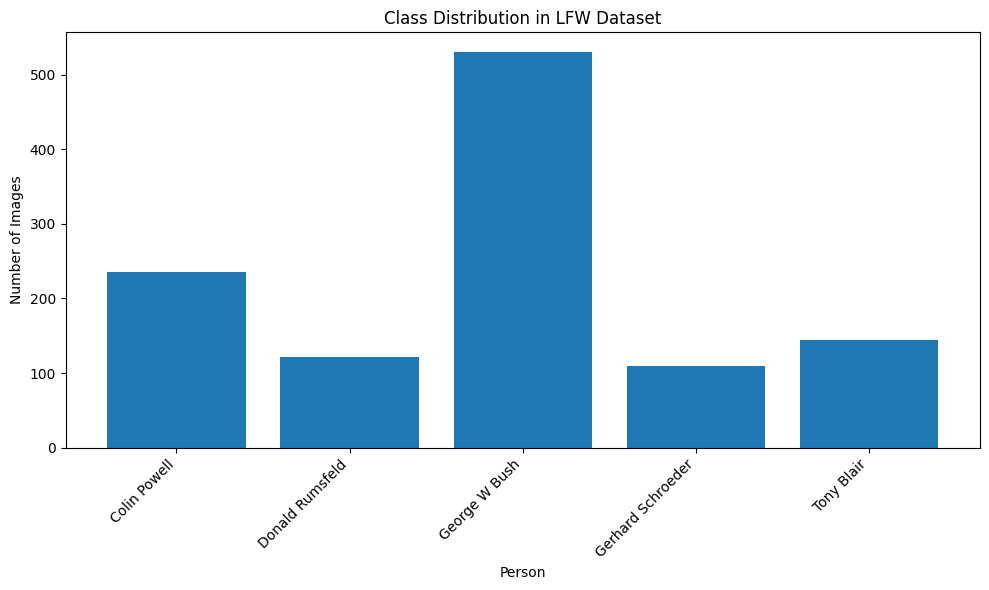

In [42]:
unique, counts = np.unique(faces.target, axis=0, return_counts=True)
plt.figure(figsize=(10, 6))
plt.bar(range(len(unique)), counts)
plt.xticks(range(len(unique)), faces.target_names[unique], rotation=45, ha='right')
plt.xlabel('Person')
plt.ylabel('Number of Images')
plt.title('Class Distribution in LFW Dataset')
plt.tight_layout()
plt.show()

### Balancing Strategy Implementation and Justification

Original samples per class: [236 121 530 109 144]
Balanced samples per class: [109 109 109 109 109]
Total samples: 1140 -> 545


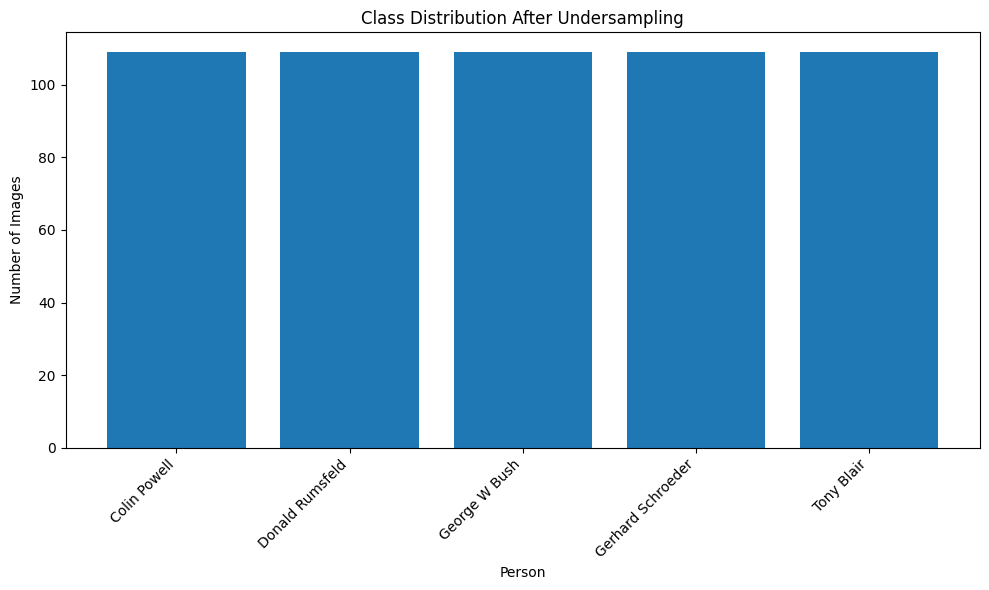

In [55]:
min_samples = np.min(counts)
balanced_indices = []
for i in unique:
    class_indices = np.where(faces.target == i)[0]
    selected = np.random.choice(class_indices, min_samples, replace=False)
    balanced_indices.extend(selected)

balanced_indices = np.array(balanced_indices)
np.random.shuffle(balanced_indices)

X_balanced = faces.data[balanced_indices]
y_balanced = faces.target[balanced_indices]

unique_balanced, counts_balanced = np.unique(y_balanced, return_counts=True)
print(f"Original samples per class: {counts}")
print(f"Balanced samples per class: {counts_balanced}")
print(f"Total samples: {len(faces.data)} -> {len(X_balanced)}")


plt.figure(figsize=(10, 6))
plt.bar(range(len(unique_balanced)), counts_balanced)
plt.xticks(range(len(unique_balanced)), faces.target_names[unique_balanced], rotation=45, ha='right')
plt.xlabel('Person')
plt.ylabel('Number of Images')
plt.title('Class Distribution After Undersampling')
plt.tight_layout()
plt.show()

### Intra-/Inter-Class Variance Comparison

In [54]:

def compute_class_variance(X, y):
    intra_class = []
    for label in np.unique(y):
        class_data = X[y == label]
        class_mean = np.mean(class_data, axis=0)
        variance = np.mean(np.sum((class_data - class_mean) ** 2, axis=1))
        intra_class.append(variance)

    class_means = []
    for label in np.unique(y):
        class_data = X[y == label]
        class_means.append(np.mean(class_data, axis=0))
    class_means = np.array(class_means)
    overall_mean = np.mean(X, axis=0)
    inter_class = np.mean(np.sum((class_means - overall_mean) ** 2, axis=1))

    return np.mean(intra_class), inter_class

intra_before, inter_before = compute_class_variance(faces.data, faces.target)
intra_after, inter_after = compute_class_variance(X_balanced, y_balanced)

print(f"Before balancing - Intra-class variance: {intra_before:.2f}, Inter-class variance: {inter_before:.2f}")
print(f"After balancing - Intra-class variance: {intra_after:.2f}, Inter-class variance: {inter_after:.2f}")



Before balancing - Intra-class variance: 61.51, Inter-class variance: 2.80
After balancing - Intra-class variance: 60.72, Inter-class variance: 2.88


## Linear SVM Baseline

### Grid Search and Reporting

C=0.001: Accuracy=0.3720, Time=0.20s
C=0.01: Accuracy=0.7805, Time=0.16s
C=0.03: Accuracy=0.8110, Time=0.13s
C=0.05: Accuracy=0.8232, Time=0.12s
C=1: Accuracy=0.8232, Time=0.15s
C=10: Accuracy=0.8232, Time=0.14s
C=100: Accuracy=0.8232, Time=0.14s

Best C: 0.05 with accuracy: 0.8232

Best Linear SVM Results (C=0.05):
Accuracy: 0.8232
Training Time: 0.12s
Confusion Matrix:
[[27  2  1  0  3]
 [ 0 25  1  1  3]
 [ 2  0 27  0  1]
 [ 1  0  1 32  1]
 [ 3  0  3  6 24]]


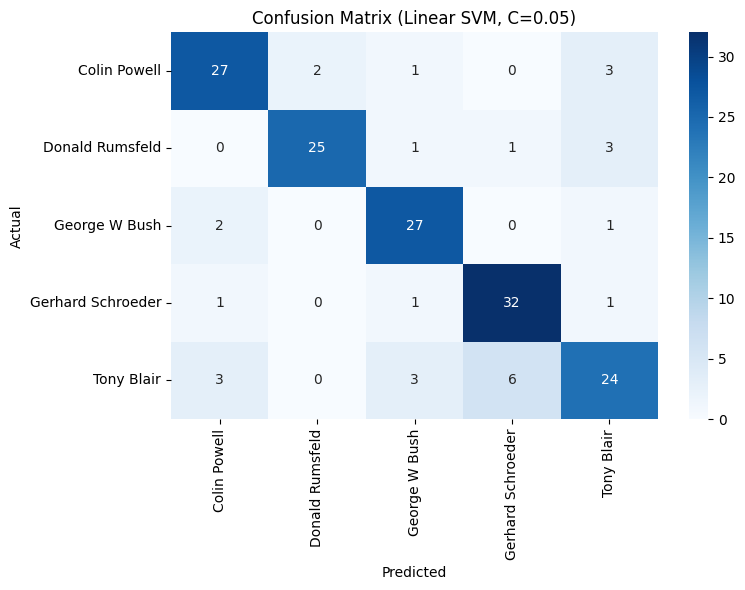

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

C_values = [0.001, 0.01, 0.03,0.05,1, 10, 100]
results = []

for C in C_values:
    start_time = time.time()
    svm = SVC(kernel='linear', C=C)
    svm.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append((C, acc, train_time))
    print(f"C={C}: Accuracy={acc:.4f}, Time={train_time:.2f}s")

best_result = max(results, key=lambda x: x[1])
best_C = best_result[0]
print(f"\nBest C: {best_C} with accuracy: {best_result[1]:.4f}")



start_time = time.time()
best_svm = SVC(kernel='linear', C=best_C)
best_svm.fit(X_train, y_train)
best_train_time = time.time() - start_time

y_pred_best = best_svm.predict(X_test)
best_acc = accuracy_score(y_test, y_pred_best)
cm = confusion_matrix(y_test, y_pred_best)

print(f"\nBest Linear SVM Results (C={best_C}):")
print(f"Accuracy: {best_acc:.4f}")
print(f"Training Time: {best_train_time:.2f}s")
print(f"Confusion Matrix:\n{cm}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=faces.target_names[unique_balanced],
            yticklabels=faces.target_names[unique_balanced])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Linear SVM, C={best_C})')
plt.tight_layout()
plt.show()

### Explanation of $C$

The hyperparameter $C$ in SVM controls the trade-off between maximizing the margin (simplicity) and minimizing the training error (accuracy).
- Small $C$ (Weak Regularization): Allows for a wider (softer) margin and more misclassification of training samples. The model prioritizes finding a large separation boundary, leading to a simpler, more generalized model, which helps prevent overfitting.
- Large $C$ (Strong Regularization): Forces a tighter (harder) margin and penalizes misclassification errors heavily. The model tries to classify all training points correctly, increasing the risk of overfitting but potentially achieving higher training accuracy.

Relevance to Facial Recognition:

In the LFW dataset, faces of the same person (intra-class) can have high variability (different poses, lighting, expressions), and faces of different people (inter-class) can look similar (e.g., similar facial structures). This means the data is not perfectly linearly separable.
- A moderate $C$ is typically optimal, allowing a soft margin to ignore noisy or outlier facial images (e.g., an unusually lit or posed photo) that would otherwise skew the decision boundary.
- A very high $C$ would lead the linear SVM to overfit to these noisy images, making the model perform poorly on the unseen test set because the tight boundary wouldn't generalize to new poses or lighting conditions.

## Kernel Experiments

### Evaluate Various Kernels

In [67]:

kernels = ['poly', 'rbf', 'sigmoid']
kernel_results = []

for kernel in kernels:
    start_time = time.time()
    svm = SVC(kernel=kernel, gamma='scale')
    svm.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    kernel_results.append((kernel, acc, train_time))
    print(f"Kernel={kernel}: Accuracy={acc:.4f}, Time={train_time:.2f}s")

Kernel=poly: Accuracy=0.8171, Time=0.14s
Kernel=rbf: Accuracy=0.7439, Time=0.18s
Kernel=sigmoid: Accuracy=0.1890, Time=0.20s


### Learning Curves and Hyperparameter Sensitivity (Poly Kernel)

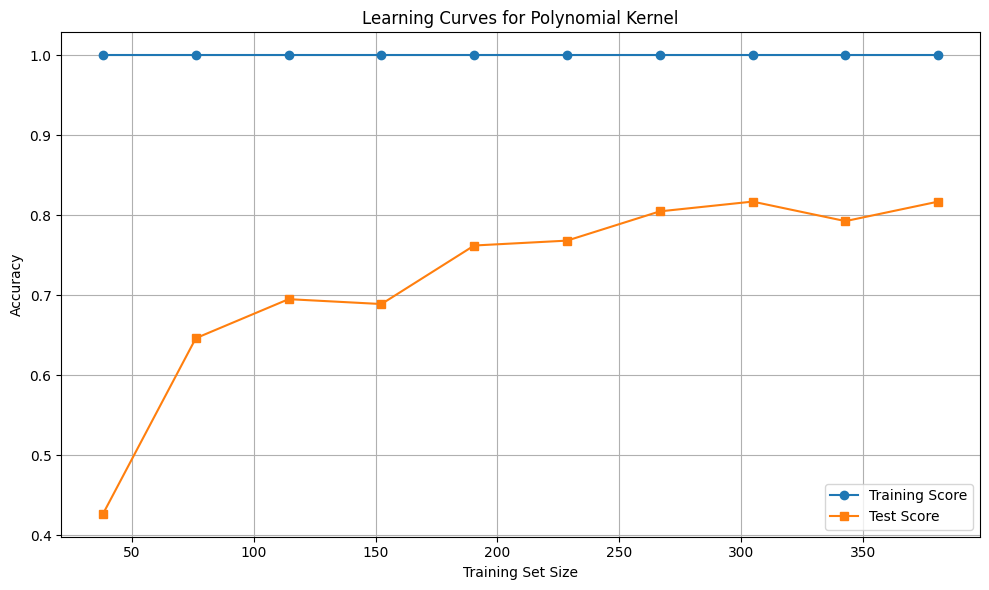

Gamma=0.0001: Test Accuracy=0.2622
Gamma=0.001: Test Accuracy=0.4756
Gamma=0.01: Test Accuracy=0.8171
Gamma=0.1: Test Accuracy=0.8171
Gamma=1: Test Accuracy=0.8171


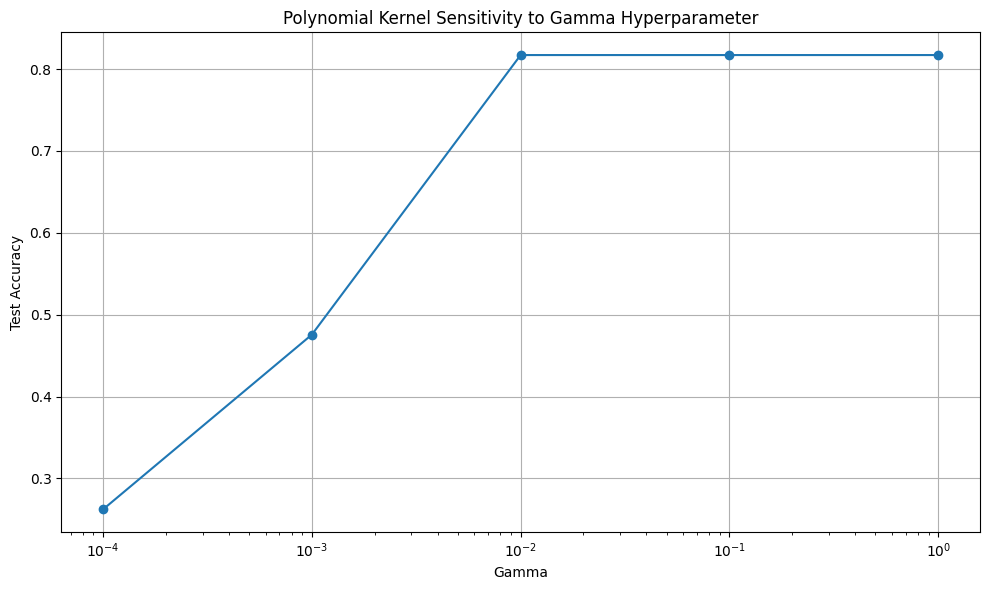

C=0.001: Test Accuracy=0.5183
C=0.01: Test Accuracy=0.8049
C=0.05: Test Accuracy=0.8232
C=0.1: Test Accuracy=0.8171
C=1: Test Accuracy=0.8171
C=10: Test Accuracy=0.8171


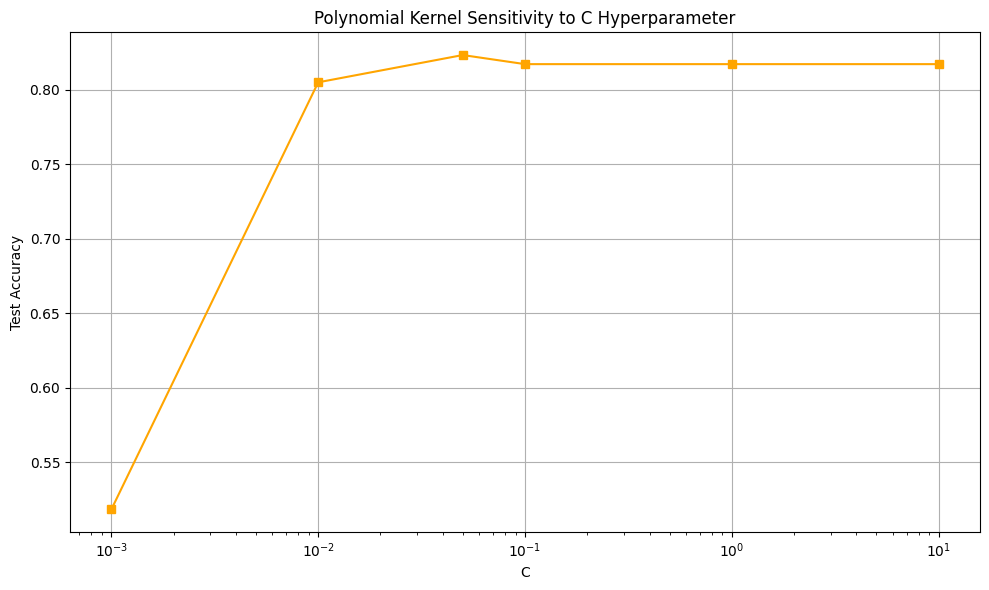

In [65]:

train_sizes = np.linspace(0.1, 1.0, 10)
train_scores = []
test_scores = []

for size in train_sizes:
    n_samples = int(len(X_train) * size)
    X_subset = X_train[:n_samples]
    y_subset = y_train[:n_samples]

    svm_poly = SVC(kernel='poly', gamma='scale')
    svm_poly.fit(X_subset, y_subset)

    train_score = svm_poly.score(X_subset, y_subset)
    test_score = svm_poly.score(X_test, y_test)

    train_scores.append(train_score)
    test_scores.append(test_score)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes * len(X_train), train_scores, label='Training Score', marker='o')
plt.plot(train_sizes * len(X_train), test_scores, label='Test Score', marker='s')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves for Polynomial Kernel')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

gamma_values = [0.0001, 0.001, 0.01, 0.1, 1]
gamma_results = []

for gamma in gamma_values:
    svm_poly = SVC(kernel='poly', gamma=gamma)
    svm_poly.fit(X_train, y_train)
    test_acc = svm_poly.score(X_test, y_test)
    gamma_results.append(test_acc)
    print(f"Gamma={gamma}: Test Accuracy={test_acc:.4f}")

plt.figure(figsize=(10, 6))
plt.semilogx(gamma_values, gamma_results, marker='o')
plt.xlabel('Gamma')
plt.ylabel('Test Accuracy')
plt.title('Polynomial Kernel Sensitivity to Gamma Hyperparameter')
plt.grid(True)
plt.tight_layout()
plt.show()

C_values_poly = [0.001, 0.01, 0.05, 0.1, 1, 10]
C_results = []

for C in C_values_poly:
    svm_poly = SVC(kernel='poly', gamma='scale', C=C)
    svm_poly.fit(X_train, y_train)
    test_acc = svm_poly.score(X_test, y_test)
    C_results.append(test_acc)
    print(f"C={C}: Test Accuracy={test_acc:.4f}")

plt.figure(figsize=(10, 6))
plt.semilogx(C_values_poly, C_results, marker='s', color='orange')
plt.xlabel('C')
plt.ylabel('Test Accuracy')
plt.title('Polynomial Kernel Sensitivity to C Hyperparameter')
plt.grid(True)
plt.tight_layout()
plt.show()